## Задание

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

## Необходимые библиотеки

In [1]:
from itertools import combinations
from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

sns.set()


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

## Подгружаем датасет

In [2]:
data = pd.read_csv('stud_math.csv')

## Анализ и подготовка датасета

In [4]:
display(data)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


In [5]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

None

    Есть данные на 395 учеников
    Целевая переменная score
    У каждой записи по 30 признаков

Название всех признаков кроме "studytime, granular" представленны в удобном для работы виде. 
В данных 13 числовых и 17 строковых признаков.

In [6]:
# Для удобства изменим название признака "studytime, granular" на studytime_granular
data.rename(
    columns={'studytime, granular': 'studytime_granular'}, inplace=True)

In [77]:
# Есть признаки которые начинаются с заглавной буквы. Приведём всё к одному виду(нижнему регистру)
data = data.rename(columns=lambda x: x.lower())

 ### Полезные функции

In [9]:
def column_info(data_column, hist_name='None'):
    # Опеределяем тип данных признака
    if data_column.dtype == 'int64' or data_column.dtype == 'float64':

        # Показываем общие данные
        display(data_column.describe())
        # Подсчитываем пропуски в дате
        print('Пропущенных значений: {}' .format(data_column[data_column.isnull() == True].size),
              '\nПроцент пропущенных данных: {}%' .format(round(data_column[data_column.isnull() == True].size*100/395)))
        # Ищем выбросы, для этого строим график
        sns.countplot(x=data_column, data=data)

    else:
        # Подсчитываем пропуски в дате
        print('Пропущенных значений: {}' .format(data_column[data_column.isnull() == True].size),
              '\nПроцент пропущенных данных: {}%' .format(round(data_column[data_column.isnull() == True].size*100/395)))
        print('Уникальные значения: {}' .format(data_column.unique()),
              '\nКоличество уникальных значений: \n{}'.format(data_column.value_counts()))
        # Выстраиваем график уникальных значений относительно друг друга
        sns.countplot(x=data_column, data=data)

### School

Пропущенных значений: 0 
Процент пропущенных данных: 0%
Уникальные значения: ['GP' 'MS'] 
Количество уникальных значений: 
GP    349
MS     46
Name: school, dtype: int64


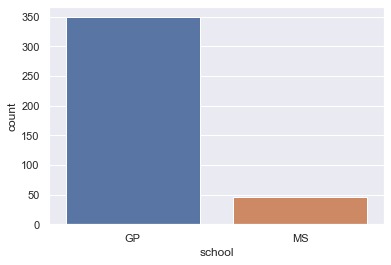

In [10]:
column_info(data.school)

В данных 2 школы

### Sex

Пропущенных значений: 0 
Процент пропущенных данных: 0%
Уникальные значения: ['F' 'M'] 
Количество уникальных значений: 
F    208
M    187
Name: sex, dtype: int64


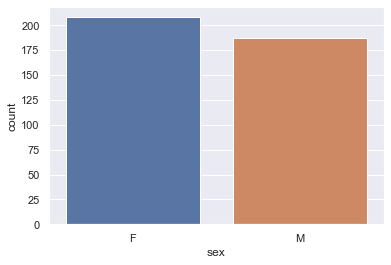

In [11]:
column_info(data.sex)

В данных два пола. Распределны приблизительно поровну

### Age

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Пропущенных значений: 0 
Процент пропущенных данных: 0%


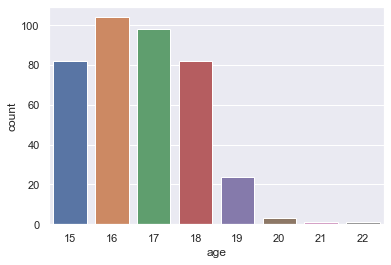

In [14]:
column_info(data.age)

Соотношение возраста к полу

<AxesSubplot:xlabel='age', ylabel='count'>

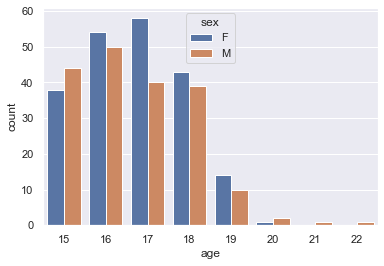

In [16]:
sns.countplot(x='age', data=data, hue='sex')

### Address

Пропущенных значений: 17 
Процент пропущенных данных: 4%
Уникальные значения: ['U' nan 'R'] 
Количество уникальных значений: 
U    295
R     83
Name: address, dtype: int64


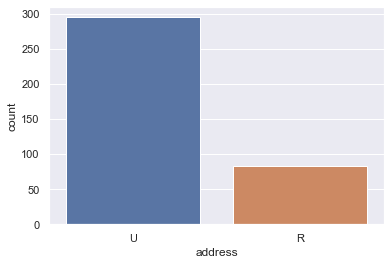

In [24]:
column_info(data.address)

Так как процент пропуска небольшой (4%) и дети из города преобладают, то заменим пропущенные данные на данные U (дети из города)

In [25]:
data.address = data.address.apply(lambda x: 'U' if pd.isnull(x) else x)

<AxesSubplot:xlabel='address', ylabel='count'>

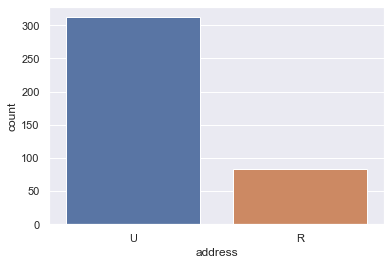

In [26]:
sns.countplot(x='address', data=data)

<AxesSubplot:xlabel='address', ylabel='count'>

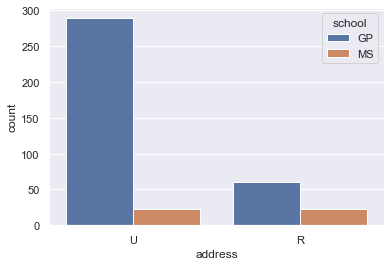

In [27]:
sns.countplot(x='address', data=data, hue='school')

Городские предпочитают отдавать детей в GP school.

### Famsize

Пропущенных значений: 27 
Процент пропущенных данных: 7%
Уникальные значения: [nan 'GT3' 'LE3'] 
Количество уникальных значений: 
GT3    261
LE3    107
Name: famsize, dtype: int64


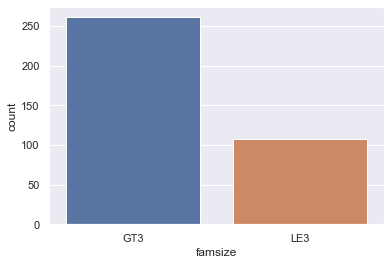

In [28]:
column_info(data.famsize)

Присутсвует 27 пропусков. Семьи из 3х преобладают в 2 раза. Заменяем пропуски на GT3

In [29]:
data.famsize = data.famsize.apply(lambda x: 'GT3' if pd.isnull(x) else x)

<AxesSubplot:xlabel='famsize', ylabel='count'>

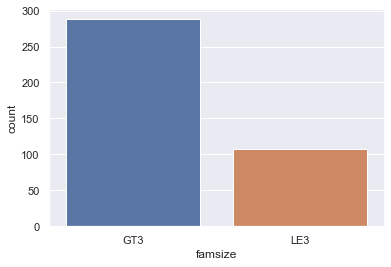

In [30]:
sns.countplot(x='famsize', data=data)

Предпочтения в школах.

<AxesSubplot:xlabel='school', ylabel='count'>

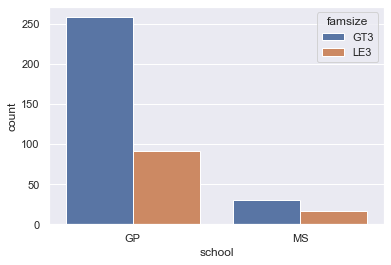

In [32]:
sns.countplot(x='school', data=data, hue='famsize')

Семьи GT3 и LE3 выбирают отдавать своих детей в школу GP.

Исследуем место проживания учеников

<AxesSubplot:xlabel='address', ylabel='count'>

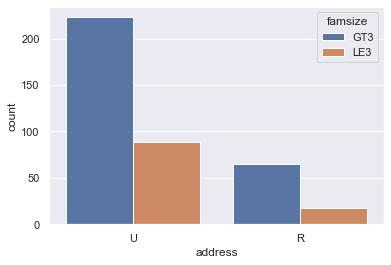

In [31]:
sns.countplot(x='address', data=data, hue='famsize')

Семьи из 3х и более живут и за городом и в городе.

### Pstatus

Пропущенных значений: 45 
Процент пропущенных данных: 11%
Уникальные значения: ['A' nan 'T'] 
Количество уникальных значений: 
T    314
A     36
Name: pstatus, dtype: int64


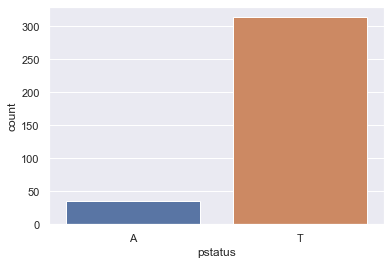

In [33]:
column_info(data.pstatus)

Всего имеются 395 учеников. У 314 родители живут вместе и у 36 порознь. Об 45 ничего не известно. Большаяя часть семей живет вместе, можем заполнить пропуски как вместе(Т)

In [34]:
data.pstatus = data.pstatus.fillna('T')

### Medu

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: medu, dtype: float64

Пропущенных значений: 3 
Процент пропущенных данных: 1%


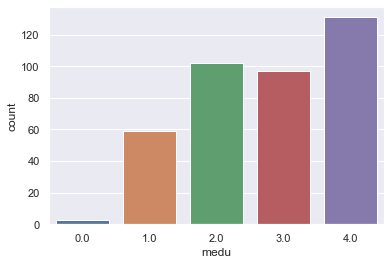

In [35]:
column_info(data.medu, 'medu')

Выбросы не обнаружены.

In [40]:
# пропуски заполняем медианой
data.medu.median()

3.0

In [41]:
data.medu = data.medu.fillna(3)

### Fedu

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: fedu, dtype: float64

Пропущенных значений: 24 
Процент пропущенных данных: 6%


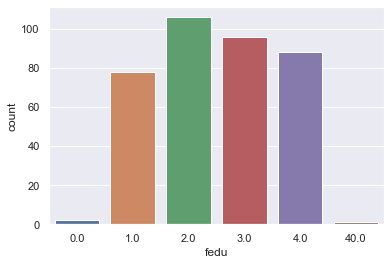

In [42]:
column_info(data.fedu, 'fedu')

Известно что признак может иметь значения 1,2,3,4. 40 в данных - скорее всего ошибка

In [43]:
# исправляем ошибку в данных
data.fedu = data.fedu.replace({40: 4})

In [44]:
# заменяем пропуски медианным занчением
data.fedu.median()

2.0

In [45]:
data.fedu = data.fedu.fillna(2)

<AxesSubplot:xlabel='fedu', ylabel='count'>

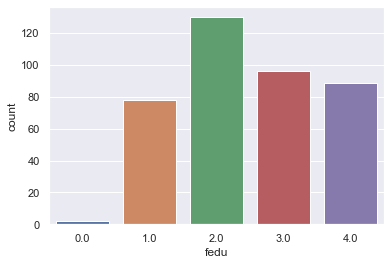

In [46]:
sns.countplot(x='fedu', data=data)

 ### Mjob

Пропущенных значений: 19 
Процент пропущенных данных: 5%
Уникальные значения: ['at_home' 'health' 'other' 'services' 'teacher' nan] 
Количество уникальных значений: 
other       133
services     98
at_home      58
teacher      55
health       32
Name: mjob, dtype: int64


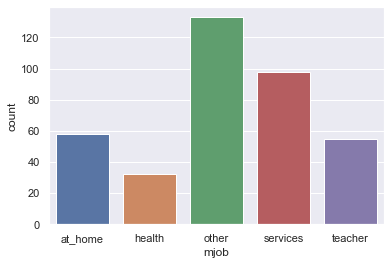

In [47]:
column_info(data.mjob)

In [48]:
# заменяем пропуски на работу матери other
data.mjob = data.mjob.fillna('other')

<AxesSubplot:xlabel='mjob', ylabel='count'>

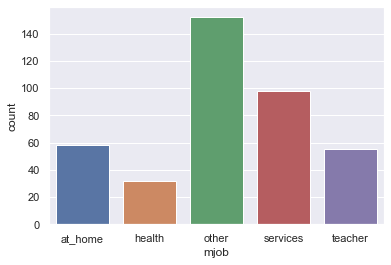

In [49]:
sns.countplot(x='mjob', data=data)

### Fjob

Пропущенных значений: 36 
Процент пропущенных данных: 9%
Уникальные значения: ['teacher' 'other' nan 'health' 'services' 'at_home'] 
Количество уникальных значений: 
other       197
services    102
teacher      29
at_home      16
health       15
Name: fjob, dtype: int64


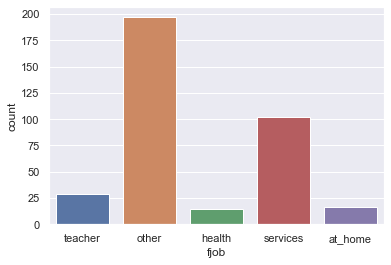

In [50]:
column_info(data.fjob)

In [51]:
# заменяем пропуски на работу отца other
data.fjob = data.fjob.fillna('other')

<AxesSubplot:xlabel='fjob', ylabel='count'>

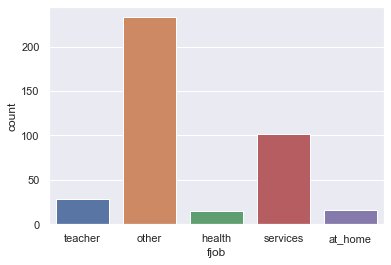

In [52]:
sns.countplot(x='fjob', data=data)

### Reason

Пропущенных значений: 17 
Процент пропущенных данных: 4%
Уникальные значения: ['course' 'other' 'home' 'reputation' nan] 
Количество уникальных значений: 
course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64


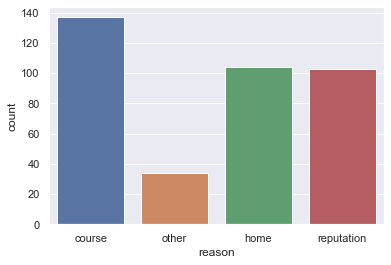

In [53]:
column_info(data.reason)

In [54]:
data.traveltime[pd.isna(data['reason']) == True]

33     1.0
63     1.0
73     1.0
77     1.0
112    NaN
137    NaN
138    1.0
140    2.0
185    1.0
186    1.0
196    1.0
263    1.0
335    1.0
363    1.0
373    1.0
382    2.0
394    1.0
Name: traveltime, dtype: float64

Из данных видно, что у пропусков признака reason школа находится близко к дому. Заполним проупски на home

In [55]:
data.reason = data.reason.fillna('home')

<AxesSubplot:xlabel='reason', ylabel='count'>

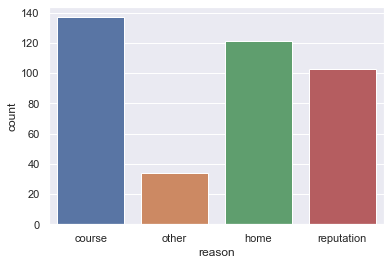

In [56]:
sns.countplot(x='reason', data=data)

### Guardian

Пропущенных значений: 31 
Процент пропущенных данных: 8%
Уникальные значения: ['mother' 'father' 'other' nan] 
Количество уникальных значений: 
mother    250
father     86
other      28
Name: guardian, dtype: int64


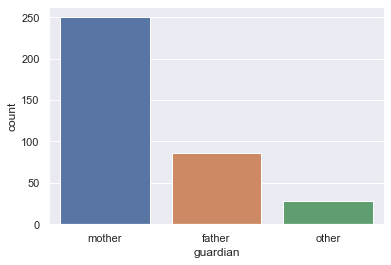

In [57]:
column_info(data.guardian)

<AxesSubplot:xlabel='guardian', ylabel='count'>

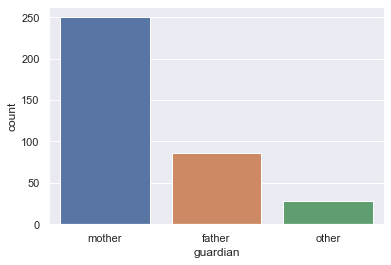

In [58]:
sns.countplot(x='guardian', data=data)

Исходя из данных, видим что преобладает как опекун мать. Можно предположить что это или семьи в разводе где мать опекун, а так же полноценные семьи. Другие - это скорее всего опекуны дедушки бабушки тёти.

Заполним пропуски на мать\полноценная семья

In [59]:
data.guardian = data.guardian.fillna('mother')

<AxesSubplot:xlabel='guardian', ylabel='count'>

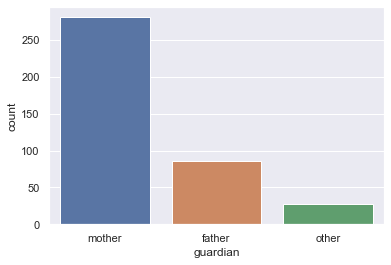

In [60]:
sns.countplot(x='guardian', data=data)

### Traveltime

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

Пропущенных значений: 28 
Процент пропущенных данных: 7%


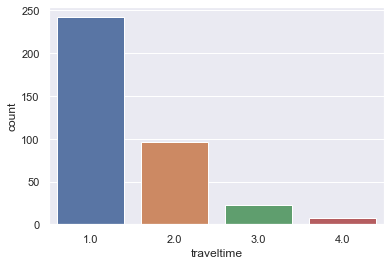

In [61]:
column_info(data.traveltime, 'traveltime')

Выбросов нет

In [63]:
# заполняем медианным значенем пропуски
data.traveltime.median()

1.0

In [64]:
data.traveltime = data.traveltime.fillna(1)

### Studytime

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

Пропущенных значений: 7 
Процент пропущенных данных: 2%


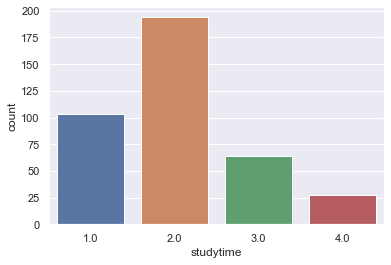

In [65]:
column_info(data.studytime, 'studytime')

Выбросов нет

In [67]:
# заполняем пропуски медианным значением
data.studytime.median()

2.0

In [68]:
data.studytime = data.studytime.fillna(2)

### Failures

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

Пропущенных значений: 22 
Процент пропущенных данных: 6%


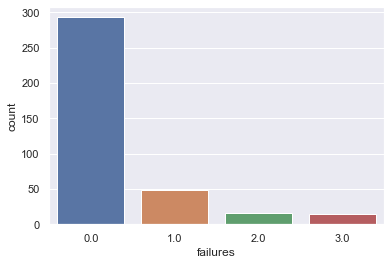

In [69]:
column_info(data.failures, 'failures')

In [71]:
# заполним пропуски 0
data.failures = data.failures.fillna(0)

 ### Schoolsup

Пропущенных значений: 9 
Процент пропущенных данных: 2%
Уникальные значения: ['yes' 'no' nan] 
Количество уникальных значений: 
no     335
yes     51
Name: schoolsup, dtype: int64


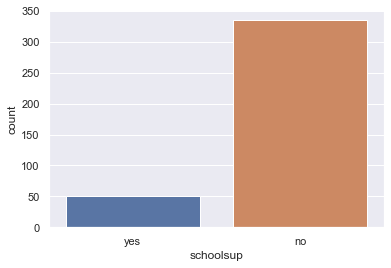

In [72]:
column_info(data.schoolsup)

In [73]:
data.schoolsup = data.schoolsup.fillna('no')

### Famsup

Пропущенных значений: 39 
Процент пропущенных данных: 10%
Уникальные значения: ['no' 'yes' nan] 
Количество уникальных значений: 
yes    219
no     137
Name: famsup, dtype: int64


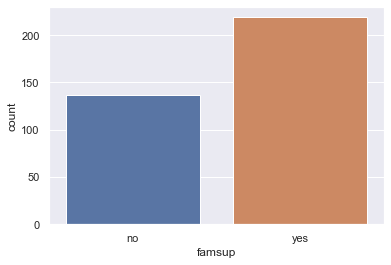

In [74]:
column_info(data.famsup)

In [79]:
# Создадим признак который содержит образование отца и матери
def data_mfedu(row):
    if row['fedu'] <= 1 and row['medu'] <= 1:
        return 0
    elif row['fedu'] <= 2 and row['medu'] <= 2:
        return 1
    elif row['fedu'] <= 3 and row['medu'] <= 3:
        return 2
    elif row['fedu'] <= 4 or row['medu'] <= 4:
        return 3
    elif row['fedu'] == 4 and row['medu'] == 4:
        return 4


data['mfedu'] = data.apply(data_mfedu, axis=1)

Сравнив образование родителей и поддержку образования в семье

<AxesSubplot:xlabel='mfedu', ylabel='count'>

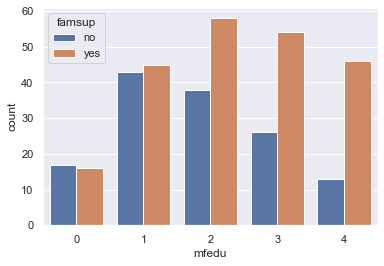

In [80]:
sns.countplot(x='mfedu', data=data, hue='famsup')

Видим что чем выше образование тем сильнее помощь дома в обучении. Добавим 2,3,4 в помощь с образованием

In [83]:
data.famsup[(data.mfedu >= 2) & (pd.isna(data['famsup']) == True)]

17     NaN
22     NaN
28     NaN
33     NaN
38     NaN
51     NaN
52     NaN
59     NaN
98     NaN
146    NaN
167    NaN
169    NaN
180    NaN
222    NaN
232    NaN
246    NaN
267    NaN
268    NaN
271    NaN
276    NaN
279    NaN
302    NaN
313    NaN
328    NaN
335    NaN
363    NaN
Name: famsup, dtype: object

In [85]:
for i in data.famsup[(data.mfedu >= 2) & (pd.isna(data['famsup']) == True)].index:
    data.at[i, 'famsup'] = 'yes'

In [86]:
data.famsup.isnull().value_counts()

False    382
True      13
Name: famsup, dtype: int64

In [87]:
# Удаляем оставшуюся дату
for i in data.famsup[pd.isna(data['famsup']) == True].index:
    data['famsup'].drop(i)

### Paid

Пропущенных значений: 40 
Процент пропущенных данных: 10%
Уникальные значения: ['no' nan 'yes'] 
Количество уникальных значений: 
no     200
yes    155
Name: paid, dtype: int64


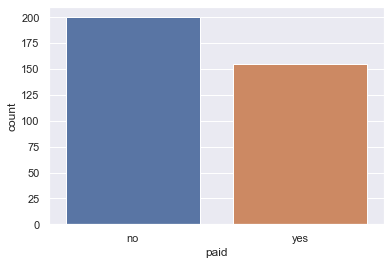

In [88]:
column_info(data.paid)

### Activities

Пропущенных значений: 14 
Процент пропущенных данных: 4%
Уникальные значения: ['no' 'yes' nan] 
Количество уникальных значений: 
yes    195
no     186
Name: activities, dtype: int64


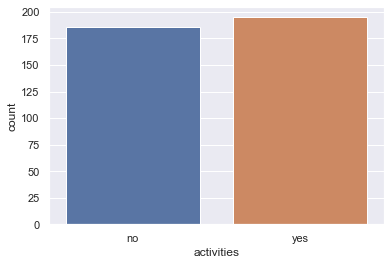

In [89]:
column_info(data.activities)

### Nursery

Пропущенных значений: 16 
Процент пропущенных данных: 4%
Уникальные значения: ['yes' 'no' nan] 
Количество уникальных значений: 
yes    300
no      79
Name: nursery, dtype: int64


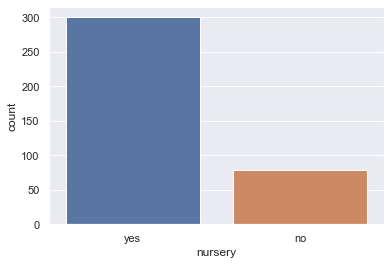

In [93]:
column_info(data.nursery)

In [94]:
# Заполним пропуски на yes т.к. пропусков мало 4%
data.nursery = data.nursery.fillna('yes')

### Higher

Пропущенных значений: 20 
Процент пропущенных данных: 5%
Уникальные значения: ['yes' nan 'no'] 
Количество уникальных значений: 
yes    356
no      19
Name: higher, dtype: int64


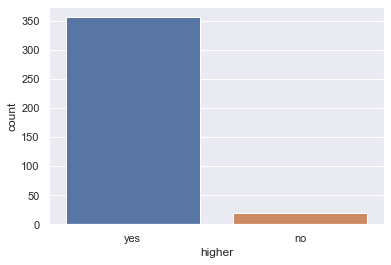

In [95]:
column_info(data.higher)

In [96]:
# Заполним пропуски на yes т.к. пропусков мало 5%
data.higher = data.higher.fillna('yes')

### Internet

Пропущенных значений: 34 
Процент пропущенных данных: 9%
Уникальные значения: [nan 'yes' 'no'] 
Количество уникальных значений: 
yes    305
no      56
Name: internet, dtype: int64


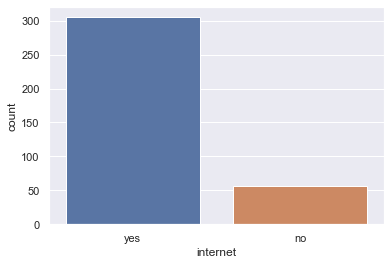

In [97]:
column_info(data.internet)

In [98]:
# Заполним пропуски на yes, т.к. пропусков мало 9%
data.internet = data.internet.fillna('yes')

### Romantic

Пропущенных значений: 31 
Процент пропущенных данных: 8%
Уникальные значения: ['no' nan 'yes'] 
Количество уникальных значений: 
no     240
yes    124
Name: romantic, dtype: int64


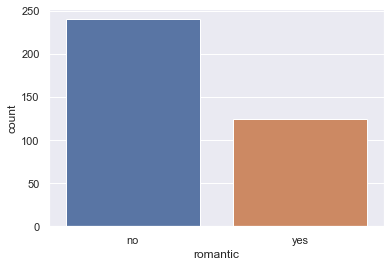

In [99]:
column_info(data.romantic)

<AxesSubplot:xlabel='age', ylabel='count'>

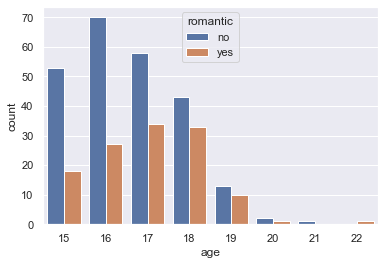

In [101]:
# Корреляция возраста и отношений
sns.countplot(x='age', data=data, hue='romantic')

Школьники младшего возраста реже в отношениях, нежели старшие

In [102]:
data.romantic.isna().value_counts()

False    364
True      31
Name: romantic, dtype: int64

In [103]:
for i in data.romantic[(data.age < 18) & (pd.isna(data['romantic']) == True)].index:
    data.at[i, 'romantic'] = 'no'

In [104]:
for i in data.romantic[pd.isna(data['romantic']) == True].index:
    data = data.drop(i)

### Famrel

count    362.000000
mean       3.936464
std        0.931949
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

Пропущенных значений: 26 
Процент пропущенных данных: 7%


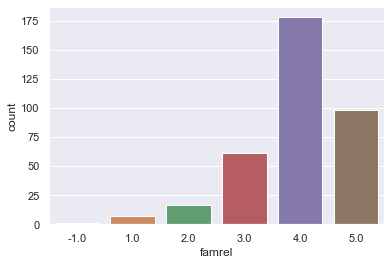

In [105]:
column_info(data.famrel, 'famrel')

Тут мы видим что есть значение -1.

In [106]:
data.famrel[data.famrel == -1]

25   -1.0
Name: famrel, dtype: float64

Одно значение. Скорее всего ошибка. Поменяю на 1

In [107]:
data.famrel = data.famrel.replace({-1: 1})

In [108]:
data.famrel.median()

4.0

In [109]:
data.famrel = data.famrel.fillna(4)

### Freetime

count    378.000000
mean       3.222222
std        0.987096
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

Пропущенных значений: 10 
Процент пропущенных данных: 3%


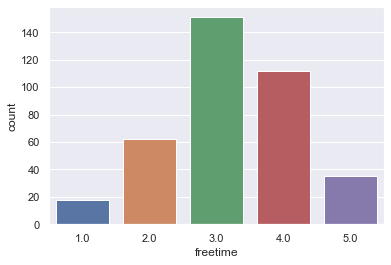

In [110]:
column_info(data.freetime, 'freetime')

In [111]:
data.freetime.median()

3.0

In [112]:
data.freetime = data.freetime.fillna(3)

### Goout

count    380.000000
mean       3.102632
std        1.117146
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

Пропущенных значений: 8 
Процент пропущенных данных: 2%


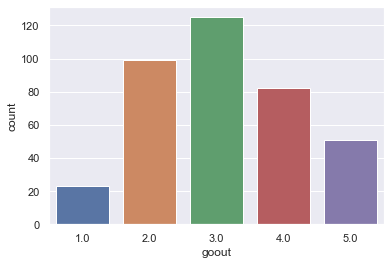

In [113]:
column_info(data.goout, 'goout')

In [114]:
data.goout.median()

3.0

In [115]:
data.goout = data.goout.fillna(3)

### Health

count    375.000000
mean       3.533333
std        1.396456
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

Пропущенных значений: 13 
Процент пропущенных данных: 3%


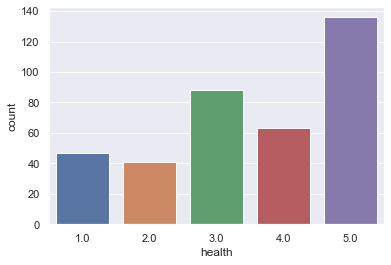

In [116]:
column_info(data.health, 'health')

In [117]:
data.health.median()

4.0

In [118]:
data.health = data.health.fillna(4)

### Absences

count    376.000000
mean       7.335106
std       23.671855
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Пропущенных значений: 12 
Процент пропущенных данных: 3%


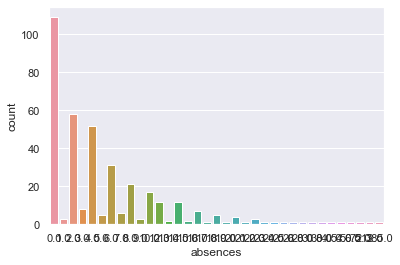

In [119]:
column_info(data.absences, 'absences')

В текущей ситуации график не подходит для построения.

<AxesSubplot:>

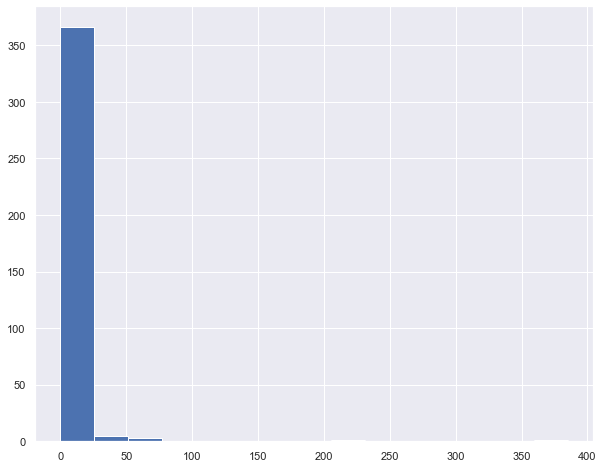

In [121]:
plt.figure(figsize=(10, 8))
data.absences.hist(bins=15)

Предположу что это отсутсвие за 1 учебный год.

In [130]:
data.absences[data.absences > 50]

Series([], Name: absences, dtype: float64)

In [129]:
for i in data[data.absences > 50].index:
    data = data.drop(i)

In [132]:
data.absences.median()

4.0

In [133]:
data.absences = data.absences.fillna(4)

Удаляем спорные данные и заполняем пропуски медианой.

### Score

count    377.000000
mean      52.307692
std       22.979079
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Пропущенных значений: 6 
Процент пропущенных данных: 2%


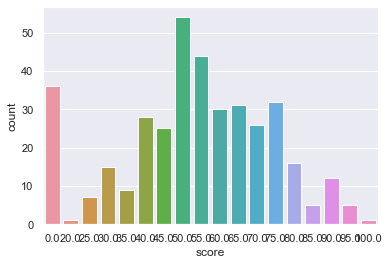

In [134]:
column_info(data.score, 'score')

<AxesSubplot:>

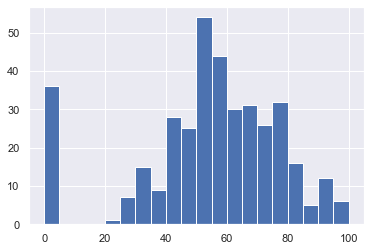

In [135]:
data.score.hist(bins=20)

In [136]:
for i in data[pd.isnull(data.score) == True].index:
    data = data.drop(i)

In [137]:
data.higher[data.score == 0].value_counts()

yes    31
no      5
Name: higher, dtype: int64

Есть 5 учеников у которых балл равен 0. Нет никого у кого бы был равен бал от 0 до 20, что странно.

Для того чтоб не портить данные, удалю всё что ниже 20

In [138]:
for i in data[data.score < 20].index:
    data = data.drop(i)

### Studytime_granular

count    334.000000
mean      -6.125749
std        2.543743
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime_granular, dtype: float64

Пропущенных значений: 7 
Процент пропущенных данных: 2%


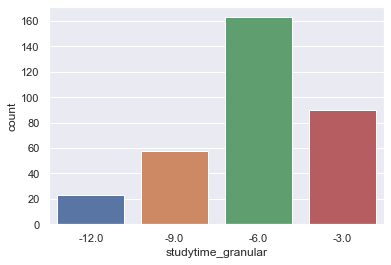

In [139]:
column_info(data.studytime_granular, 'studytime_granular')

Помним что есть признак как studytime. Сделаем корреляционный анализ переменных.

,age,medu,fedu,traveltime,studytime,failures,studytime_granular,famrel,freetime,goout,health,absences,score,mfedu
age,1.000000,-0.133243,-0.129048,0.116762,-0.017881,0.225803,0.018069,0.061582,-0.015467,0.125161,-0.068325,0.250375,-0.123925,-0.132029
medu,-0.133243,1.000000,0.575457,-0.156669,0.075746,-0.201954,-0.076363,-0.006488,0.032910,0.087536,-0.044601,0.083548,0.190163,0.882337
fedu,-0.129048,0.575457,1.000000,-0.117459,-0.010216,-0.254623,0.010398,-0.009193,-0.032447,0.037852,0.007304,0.022432,0.117488,0.817656
traveltime,0.116762,-0.156669,-0.117459,1.000000,-0.096232,0.087662,0.097518,-0.031971,-0.008845,0.043409,-0.021349,0.002655,-0.073265,-0.139484
studytime,-0.017881,0.075746,-0.010216,-0.096232,1.000000,-0.148078,-1.000000,0.055244,-0.142990,-0.043293,-0.084061,-0.092650,0.150099,0.027197
failures,0.225803,-0.201954,-0.254623,0.087662,-0.148078,1.000000,0.149856,-0.015177,0.105647,0.116390,0.055280,0.204555,-0.290379,-0.239761
studytime_granular,0.018069,-0.076363,0.010398,0.097518,-1.000000,0.149856,1.000000,-0.056035,0.145453,0.043764,0.084768,0.093039,-0.152675,-0.027323
famrel,0.061582,-0.006488,-0.009193,-0.031971,0.055244,-0.015177,-0.056035,1.000000,0.146952,0.033073,0.108370,-0.101147,0.060684,-0.030900
freetime,-0.015467,0.032910,-0.032447,-0.008845,-0.142990,0.105647,0.145453,0.146952,1.000000,0.281565,0.066089,-0.020242,-0.008406,0.014253
goout,0.125161,0.087536,0.037852,0.043409,-0.043293,0.116390,0.043764,0.033073,0.281565,1.000000,-0.001747,0.124610,-0.179068,0.069835


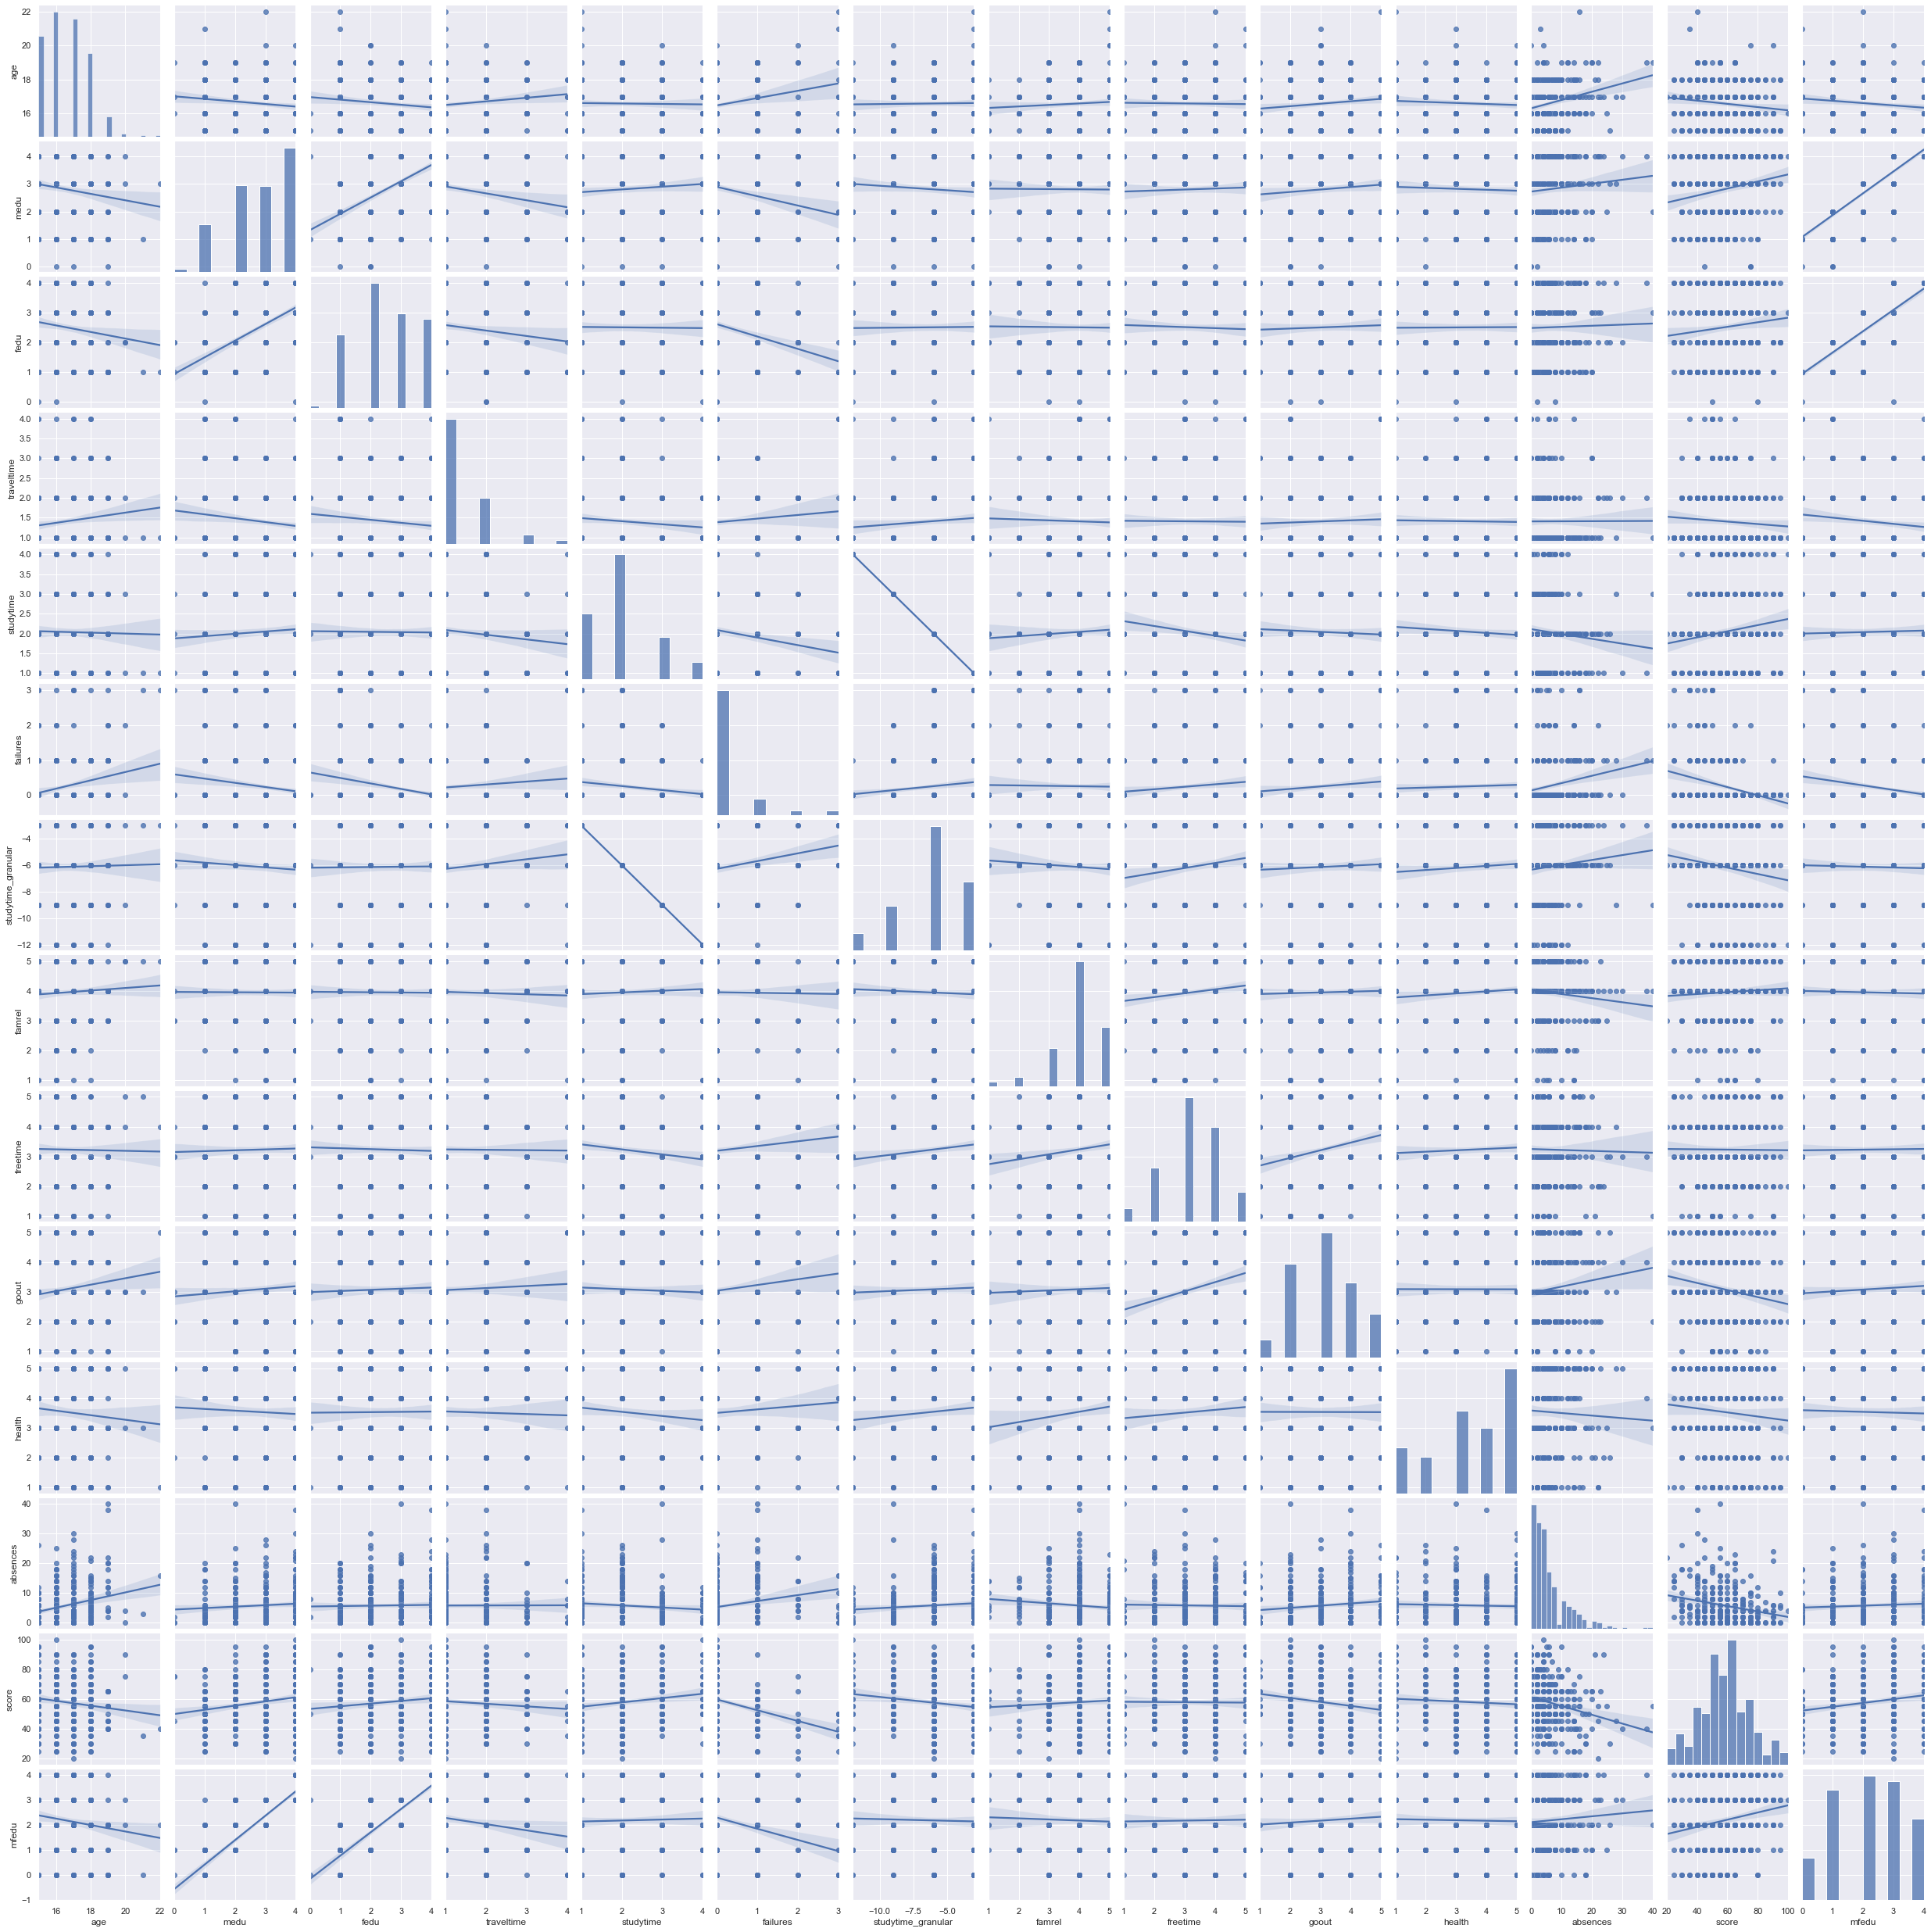

In [146]:
df = data.select_dtypes('number').astype('float64')

sns.pairplot(df, kind='reg')
df.corr()

studytime и studytime_granular имеют корреляцию -1. Удалю studytime_granular

In [147]:
data = data.drop(columns='studytime_granular')

Исходя из информации можно заметить, что есть положительная корреляция образования родителей между собой. Видна связь возраста с оценками, чем старше ученик, тем ниже оценка, растут пропуски занятий, слабеет здоровье. Присутсвует отрицательная корреляция образования родителей и неудачи учеников. Видна положительная корреляция уровня образования родителй, допольнительных занятий с оценками и отношений в семье.

Приступим теперь к анализу влияния номинативных переменных

In [148]:
def nominative_analysis(column):
    # Выискиваем все униикальные признаки
    quniq = data[column].value_counts().index
    # Составляем комбинации с признаком
    fullset_combinations = list(combinations(quniq, 2))
    # Используем tтест на комбинациях не забывая про Бонферони
    for comb in fullset_combinations:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'],
                     data.loc[data.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(fullset_combinations):
            print('Найдены статистически значимые различия для', column)
            # Построим boxplot при нахождении различий
            fi, ax = plt.subplots(figsize=(6, 5))
            sns.boxplot(x=column, y='score', data=data, ax=ax)
            ax.set_title('Boxplot for '+column)
            plt.show()
            break

Найдены статистически значимые различия для sex


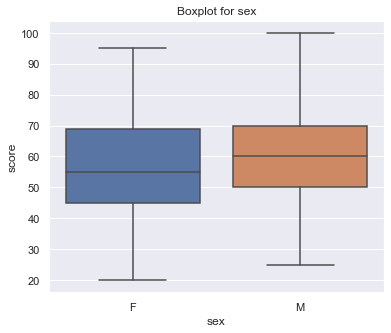

Найдены статистически значимые различия для address


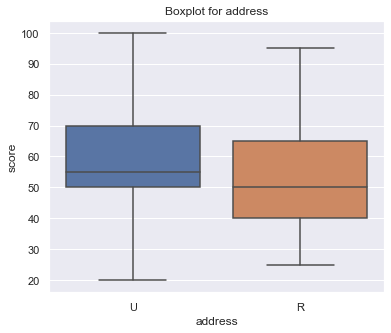

Найдены статистически значимые различия для mjob


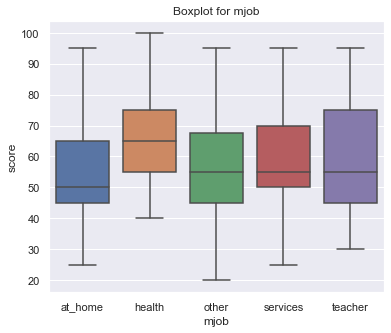

Найдены статистически значимые различия для studytime


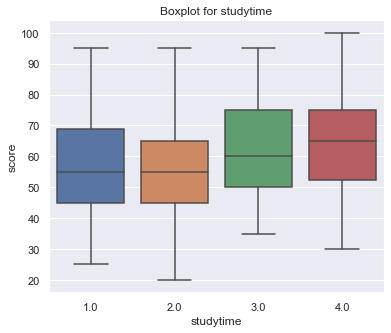

Найдены статистически значимые различия для schoolsup


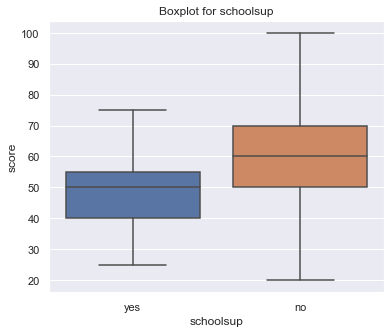

Найдены статистически значимые различия для goout


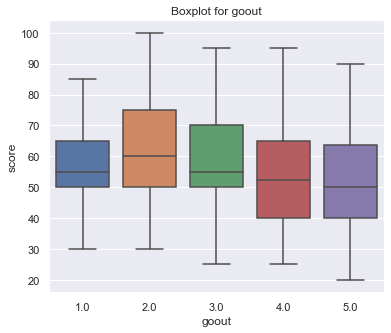

Найдены статистически значимые различия для mfedu


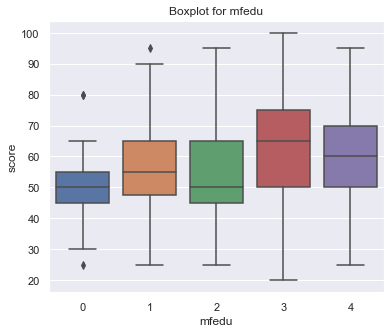

In [153]:
for boxes in ['school', 'sex', 'address', 'famsize', 'pstatus',
              'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
              'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
              'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
              'health', 'mfedu']:
    nominative_analysis(boxes)

Получили 7 признаков, которые скорее всего влияют на итоговую оценку.

Соединим номинативные признаки с числовыми, которые коррелируют с целевой переменной score

In [154]:
nomcor_data = pd.DataFrame()

In [155]:
nomcor_data = data.drop(columns=['school', 'famsize', 'pstatus',
                                 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
                                 'famsup', 'paid', 'activities', 'nursery', 'internet',
                                 'famrel', 'freetime', 'goout', 'health'])

In [156]:
display(nomcor_data.head())
nomcor_data.info()

,sex,age,address,medu,fedu,mjob,failures,schoolsup,higher,romantic,absences,score,mfedu
0,F,18,U,4.0,4.0,at_home,0.0,yes,yes,no,6.0,30.0,4
1,F,17,U,1.0,1.0,at_home,0.0,no,yes,no,4.0,30.0,0
2,F,15,U,1.0,1.0,at_home,3.0,yes,yes,no,10.0,50.0,0
3,F,15,U,4.0,2.0,health,0.0,no,yes,yes,2.0,75.0,3
4,F,16,U,3.0,3.0,other,0.0,no,yes,no,4.0,50.0,2


<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 394
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex        341 non-null    object 
 1   age        341 non-null    int64  
 2   address    341 non-null    object 
 3   medu       341 non-null    float64
 4   fedu       341 non-null    float64
 5   mjob       341 non-null    object 
 6   failures   341 non-null    float64
 7   schoolsup  341 non-null    object 
 8   higher     341 non-null    object 
 9   romantic   341 non-null    object 
 10  absences   341 non-null    float64
 11  score      341 non-null    float64
 12  mfedu      341 non-null    int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 47.3+ KB


In [158]:
for colum in ['sex', 'address', 'mjob', 'schoolsup', 'higher', 'romantic', 'mfedu']:
    nomcor_data = nomcor_data.join(pd.get_dummies(data[colum], prefix=colum))
    nomcor_data = nomcor_data.drop(columns=[colum])

In [160]:
display(nomcor_data.head())
nomcor_data.info()

,age,medu,fedu,failures,absences,score,sex_F,sex_M,address_R,address_U,mjob_at_home,mjob_health,mjob_other,mjob_services,mjob_teacher,schoolsup_no,schoolsup_yes,higher_no,higher_yes,romantic_no,romantic_yes,mfedu_0,mfedu_1,mfedu_2,mfedu_3,mfedu_4
0,18,4.0,4.0,0.0,6.0,30.0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1
1,17,1.0,1.0,0.0,4.0,30.0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0
2,15,1.0,1.0,3.0,10.0,50.0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0
3,15,4.0,2.0,0.0,2.0,75.0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0
4,16,3.0,3.0,0.0,4.0,50.0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 394
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            341 non-null    int64  
 1   medu           341 non-null    float64
 2   fedu           341 non-null    float64
 3   failures       341 non-null    float64
 4   absences       341 non-null    float64
 5   score          341 non-null    float64
 6   sex_F          341 non-null    uint8  
 7   sex_M          341 non-null    uint8  
 8   address_R      341 non-null    uint8  
 9   address_U      341 non-null    uint8  
 10  mjob_at_home   341 non-null    uint8  
 11  mjob_health    341 non-null    uint8  
 12  mjob_other     341 non-null    uint8  
 13  mjob_services  341 non-null    uint8  
 14  mjob_teacher   341 non-null    uint8  
 15  schoolsup_no   341 non-null    uint8  
 16  schoolsup_yes  341 non-null    uint8  
 17  higher_no      341 non-null    uint8  
 18  higher_yes

### Подводим итоги анализа

1. Полученые данные были довольно чистыми. Выбросы обнаружены лишь в absences.
2. Существует большое число пропусков, возможно это следствие системных ошибок. В целом, была проведена работа по обработке пропусков, но не все пропуски получилось обработать.
3. Разбор номинативных данных говорит о том, что важными для построения будут эти признаки: sex, address, mjob, schoolsup, higher, romantic, mfedu